In [35]:
# Import libraries
import json
import time
import threading
from datetime import datetime
from twython import Twython

# Imports the keys from the python file
from twitter_key import api_key, api_secret

In [36]:
# Assigns the keys to the variables
APP_KEY = api_key
APP_SECRET = api_secret

# Create a Twython object called Twitter
# Set this up using your Twitter Keys
# Say we are going to use OAuth 2
twython_setup = Twython(APP_KEY, APP_SECRET, oauth_version=2)

# Get an OAuth2 access token, save as variable so we can launch our 
OAUTH2_ACCESS_TOKEN = twython_setup.obtain_access_token()

# Create a Twython Object we will use for our access to the API
my_twython = Twython(APP_KEY, access_token=OAUTH2_ACCESS_TOKEN)

In [37]:
# Input the search term you want to search on
search_term='' # SET A SEARCH TERM LIKE 'TRUMP'
# CAN LEAVE search_term BLANK IF YOU WANT ALL TWEETS NEAR A SPECIFIC LOCATION
# Setup a Lat Lon
latlong=[1.1542311,-76.6515237] # Downtown Mocoa
# Setup a search distance
distance='5mi'
# Set result type (can be 'recent', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets= 100


# Fetches tweets with a given query at a given lat-long.
def get_tweets_by_location( latlong=None ):
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

# test run our function
get_tweets_by_location(latlong)

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Tue Mar 06 18:10:45 +0000 2018',
  'entities': {'hashtags': [],
   'symbols': [],
   'urls': [],
   'user_mentions': [{'id': 395680230,
     'id_str': '395680230',
     'indices': [3, 11],
     'name': 'EL PINTA BLACK',
     'screen_name': 'PinTa97'},
    {'id': 26536125,
     'id_str': '26536125',
     'indices': [13, 28],
     'name': 'América En La Red',
     'screen_name': 'Americaenlared'},
    {'id': 557927601,
     'id_str': '557927601',
     'indices': [29, 43],
     'name': 'América de Cali',
     'screen_name': 'AmericadeCali'}]},
  'favorite_count': 0,
  'favorited': False,
  'geo': None,
  'id': 971085691118669825,
  'id_str': '971085691118669825',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'es',
  'metadata': {'iso_language_code': 'es', 'result_ty

In [38]:
# Does pretty much what its long name suggests.
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 600
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 100
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets = get_tweets_by_location(latlong) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets

In [39]:
# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

At 0 seconds, added 37 new tweets, for a total of 37
At 100 seconds, added 0 new tweets, for a total of 37
At 200 seconds, added 0 new tweets, for a total of 37
At 300 seconds, added 0 new tweets, for a total of 37
At 400 seconds, added 0 new tweets, for a total of 37
At 500 seconds, added 0 new tweets, for a total of 37
37 Tweets retrieved.


In [20]:
# Import some additional libraries that will allow us to plot and interact with the operating system
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Get the file names from a given directory
file_dir = "data" # Set this to where your JSON saved
# Get only the JSONs we have saved
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# create an empty dataframe with columns for each property
df_tweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location','user','raw_source','data_point','time'])

# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) # creates a Python dictionary of our json
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_tweets.loc[key,val] = val
                
df_tweets

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time
970437320527691778,970437320527691778,None,None,RT @lis_pleon: @jxstmendes Lo último es tu lis...,,773713135253483520,{'created_at': 'Sun Mar 04 23:14:21 +0000 2018...,none,Sun Mar 04 23:14:21 +0000 2018
970437216752295939,970437216752295939,None,None,RT @lis_pleon: @jxstmendes Lo último es tu lis...,"Mocoa, Colombia",811205960274477057,{'created_at': 'Sun Mar 04 23:13:56 +0000 2018...,none,Sun Mar 04 23:13:56 +0000 2018
970437192878354433,970437192878354433,None,None,RT @lis_pleon: @jxstmendes Lo último es tu lis...,,962011921586167810,{'created_at': 'Sun Mar 04 23:13:51 +0000 2018...,none,Sun Mar 04 23:13:51 +0000 2018
970436928150622208,970436928150622208,None,None,@jxstmendes Lo último es tu lista realmente ro...,"Mocoa, Colombia",811205960274477057,{'created_at': 'Sun Mar 04 23:12:48 +0000 2018...,none,Sun Mar 04 23:12:48 +0000 2018
970436720784302081,970436720784302081,None,None,RT @lis_pleon: @merivatic @fannicasper Esto se...,Honeymoon,960585701409640448,{'created_at': 'Sun Mar 04 23:11:58 +0000 2018...,none,Sun Mar 04 23:11:58 +0000 2018
970436684998471680,970436684998471680,None,None,RT @lis_pleon: @merivatic @fannicasper Esto se...,"Mocoa, Colombia",811205960274477057,{'created_at': 'Sun Mar 04 23:11:50 +0000 2018...,none,Sun Mar 04 23:11:50 +0000 2018
970436658855337984,970436658855337984,None,None,@As_TomasRoncero Hijo de puta jajajajajajaja s...,"Mocoa, Colombia",1731420859,{'created_at': 'Sun Mar 04 23:11:43 +0000 2018...,none,Sun Mar 04 23:11:43 +0000 2018
970436509039038464,970436509039038464,None,None,@MendesArmyMex Cuenta si te caíste en una alca...,"Mocoa, Colombia",811205960274477057,{'created_at': 'Sun Mar 04 23:11:08 +0000 2018...,none,Sun Mar 04 23:11:08 +0000 2018
970436346169839616,970436346169839616,None,None,RT @lis_pleon: @merivatic @fannicasper Esto se...,,970430522571702272,{'created_at': 'Sun Mar 04 23:10:29 +0000 2018...,none,Sun Mar 04 23:10:29 +0000 2018
970436097086980097,970436097086980097,None,None,@DeporteTotalFM Es q si tienen problemas y jue...,"Mocoa, Colombia",719333308589588480,{'created_at': 'Sun Mar 04 23:09:30 +0000 2018...,none,Sun Mar 04 23:09:30 +0000 2018


### df_tweets.drop_duplicates('tweet_id')

In [30]:
df_tweets = df_tweets.astype(str)
df_tweets.duplicated()

970437320527691778    False
970437216752295939    False
970437192878354433    False
970436928150622208    False
970436720784302081    False
970436684998471680    False
970436658855337984    False
970436509039038464    False
970436346169839616    False
970436097086980097    False
970435782954700802    False
970434081656856576    False
970433586909384704    False
970433574557057024    False
970433540251930625    False
970431908021784576    False
970431372002283520    False
970431033287102464    False
970430357223936002    False
970428534987608064    False
970427067098632192    False
970424730242166784    False
970423454708183040    False
970422151735054336    False
970421983568695297    False
970421813196058628    False
970420167392964613    False
970418964370280449    False
970418942001885185    False
970418315696005122    False
                      ...  
970509391064682510    False
970510123234922496    False
970510086509645826    False
970510309390725122    False
970510206688952326  

In [31]:
df_tweets.dtypes

tweet_id      object
lat           object
lon           object
content       object
location      object
user          object
raw_source    object
data_point    object
time          object
dtype: object

In [32]:
df_tweets['location'].unique()

array(['', 'Mocoa, Colombia', 'Honeymoon', 'mocoa', 'Puerto Asis Putumayo',
       'Mocoa- Putumayo', 'Mocoa, Putumayo. Colombia', 'México',
       'Mocoa -ptyo', 'Chile', 'Latinoamérica', 'London, England',
       'Mocoa Putumayo Colombia', 'Argentina', 'Popayán, Colombia',
       'Ciudad Autónoma de Buenos Aire', 'Ecuador', 'sibundoy', 'mocoa ',
       'Santiago, Chile', 'Mocoa Putumayo', 'Tampico, Tamaulipas',
       'Neiva, Colombia', '🇦🇷', 'Hogwarts ', 'Mocoa, Putumayo',
       'La Florida, Chile', "Shawn's bed ahre🌈", 'Hogwarts', 'COLOMBIA',
       'Cairo, Egypt', 'Mocoa Putumayo ', 'Buenos Aires, Argentina',
       'Mocoa, Putumayo, Colombia', 'Villavicencio', 'Bogotá, Colombia',
       'Argentina ', 'Mendes Army', 'Cafundó do Judas '], dtype=object)

In [33]:
grouped_tweets = df_tweets.groupby('user')
count_tweets = grouped_tweets['user'].count()
df_count_tweets = count_tweets.to_frame()
df_count_tweets.columns = ['Count']
df_count_tweets.index.names = ['User']
df_count_tweets.sort_index()

,Count
User,
112005583,1
1202062040,3
124057793,2
130239924,5
142321686,1
15050684,7
1697523650,1
1731420859,1
17572957,1


In [34]:
df_tweets.to_csv('Mocoa-5hrs.csv', sep=',', encoding='utf-8')

In [27]:
grouped_tweets2 = df5.groupby('location')
count_tweets = grouped_tweets2['location'].count()
df_count_tweets2 = count_tweets.to_frame()
df_count_tweets2.columns = ['Count']
df_count_tweets2.index.names = ['Location']
df_count_tweets2.sort_index()

NameError: name 'df5' is not defined

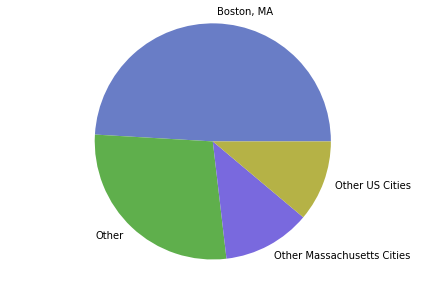

In [65]:
# Create a list of colors (from iWantHue)
colors = ["#697dc6","#5faf4c","#7969de","#b5b246",
          "#cc54bc","#4bad89","#d84577","#4eacd7",
          "#cf4e33","#894ea8","#cf8c42","#d58cc9",
          "#737632","#9f4b75","#c36960"]

# Create a pie chart
plt.pie( df_count_tweets2['Count'], labels=df_count_tweets2.index.get_values(), shadow=False, colors=colors)

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

In [66]:
# Create a filter from df_tweets filtering only those that have values for lat and lon
df_tweets_with_location = df_tweets[df_tweets.lon.notnull() & df_tweets.lat.notnull()]
df_tweets_with_location

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time
837068268540088324,837068268540088324,-71.0589,42.3601,We're #hiring! Read about our latest #job open...,United States,4036152552,{'created_at': 'Wed Mar 01 22:33:21 +0000 2017...,none,Wed Mar 01 22:33:21 +0000 2017


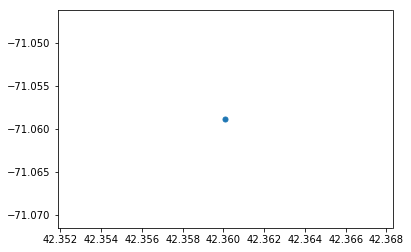

In [67]:
#Only one point to plot
plt.scatter(df_tweets_with_location['lon'],df_tweets_with_location['lat'], s=25)
plt.show()

In [11]:
# Part 2, with search term "Trump"
import json
import time
import threading
from datetime import datetime
from twython import Twython

# Imports the keys from the python file
from twitter_key import api_key, api_secret

In [12]:
# Assigns the keys to the variables
APP_KEY = api_key
APP_SECRET = api_secret

# Create a Twython object called Twitter
# Set this up using your Twitter Keys
# Say we are going to use OAuth 2
twython_setup = Twython(APP_KEY, APP_SECRET, oauth_version=2)

# Get an OAuth2 access token, save as variable so we can launch our 
OAUTH2_ACCESS_TOKEN = twython_setup.obtain_access_token()

# Create a Twython Object we will use for our access to the API
my_twython = Twython(APP_KEY, access_token=OAUTH2_ACCESS_TOKEN)

In [17]:
# Input the search term you want to search on
search_term='Trump' # SET A SEARCH TERM LIKE 'TRUMP'
# CAN LEAVE search_term BLANK IF YOU WANT ALL TWEETS NEAR A SPECIFIC LOCATION
# Setup a Lat Lon
latlong=[42.3601,-71.0589] # Downtown Boston
# Setup a search distance
distance='25mi'
# Set result type (can be 'recent', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets= 4


# Fetches tweets with a given query at a given lat-long.
def get_tweets_by_location( latlong=None ):
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

# test run our function
get_tweets_by_location(latlong)

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Mar 03 02:25:01 +0000 2017',
  'entities': {'hashtags': [],
   'symbols': [],
   'urls': [],
   'user_mentions': [{'id': 2910362224,
     'id_str': '2910362224',
     'indices': [3, 16],
     'name': 'BillNi',
     'screen_name': 'WilliamNiosi'},
    {'id': 534976479,
     'id_str': '534976479',
     'indices': [18, 33],
     'name': 'Mike From Woburn',
     'screen_name': 'MikeFromWoburn'}]},
  'favorite_count': 0,
  'favorited': False,
  'geo': None,
  'id': 837488955725598720,
  'id_str': '837488955725598720',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
  'place': None,
  'retweet_count': 2,
  'retweeted': False,
  'retweeted_status': {'contributors': None,
   'coordinates': None,


In [18]:
# Does pretty much what its long name suggests.
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 900
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 60
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets = get_tweets_by_location(latlong) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets

In [19]:
# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'trump/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

At 0 seconds, added 2 new tweets, for a total of 2
At 60 seconds, added 2 new tweets, for a total of 4
At 120 seconds, added 4 new tweets, for a total of 8
At 180 seconds, added 3 new tweets, for a total of 11
At 240 seconds, added 4 new tweets, for a total of 15
At 300 seconds, added 4 new tweets, for a total of 19
At 360 seconds, added 4 new tweets, for a total of 23
At 420 seconds, added 4 new tweets, for a total of 27
At 480 seconds, added 3 new tweets, for a total of 30
At 540 seconds, added 4 new tweets, for a total of 34
At 600 seconds, added 3 new tweets, for a total of 37
At 660 seconds, added 4 new tweets, for a total of 41
At 720 seconds, added 4 new tweets, for a total of 45
At 780 seconds, added 4 new tweets, for a total of 49
At 840 seconds, added 4 new tweets, for a total of 53
53 Tweets retrieved.


In [21]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# Get the file names from a given directory
file_dir = "trump" # Set this to where your JSON saved
# Get only the JSONs we have saved
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# create an empty dataframe with columns for each property
df_tweets_trump = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location','user','raw_source','data_point','time'])

# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) # creates a Python dictionary of our json
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_tweets_trump.loc[key,val] = val
                
df_tweets_trump

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time
837488955725598720,837488955725598720,None,None,RT @WilliamNiosi: @MikeFromWoburn wanna know i...,,929863172,{'created_at': 'Fri Mar 03 02:25:01 +0000 2017...,none,Fri Mar 03 02:25:01 +0000 2017
837488913849573377,837488913849573377,None,None,RT @dabeard: The only thing the #Trump team as...,,99643216,{'created_at': 'Fri Mar 03 02:24:51 +0000 2017...,none,Fri Mar 03 02:24:51 +0000 2017
837489353257598976,837489353257598976,None,None,The #Netherlands welcomes #tRUMP in his own wo...,"Quincy, MA",175899052,{'created_at': 'Fri Mar 03 02:26:36 +0000 2017...,none,Fri Mar 03 02:26:36 +0000 2017
837489346815000576,837489346815000576,None,None,RT @jciv: Donald Trump Jr. Was Likely Paid at ...,,15969979,{'created_at': 'Fri Mar 03 02:26:34 +0000 2017...,none,Fri Mar 03 02:26:34 +0000 2017
837489636939223040,837489636939223040,None,None,RT @dabeard: The only thing the #Trump team as...,Somewhere over there...,391068552,{'created_at': 'Fri Mar 03 02:27:43 +0000 2017...,none,Fri Mar 03 02:27:43 +0000 2017
837489608166412288,837489608166412288,None,None,RT @dabeard: While #Trump is waiting to releas...,,325572581,{'created_at': 'Fri Mar 03 02:27:37 +0000 2017...,none,Fri Mar 03 02:27:37 +0000 2017
837489577174659072,837489577174659072,None,None,"RT @7News: Trump, aboard Navy carrier, vows to...",Boston,1166774665,{'created_at': 'Fri Mar 03 02:27:29 +0000 2017...,none,Fri Mar 03 02:27:29 +0000 2017
837489558342234114,837489558342234114,None,None,RT @dabeard: While #Trump is waiting to releas...,"Texas, USA",703520844,{'created_at': 'Fri Mar 03 02:27:25 +0000 2017...,none,Fri Mar 03 02:27:25 +0000 2017
837489833413079040,837489833413079040,None,None,RT @Cpin42: BREAKING: Trump Picks Seth Jession...,"Cedar Falls, IA",312905622,{'created_at': 'Fri Mar 03 02:28:30 +0000 2017...,none,Fri Mar 03 02:28:30 +0000 2017
837489832888688640,837489832888688640,None,None,RT @dabeard: The only thing the #Trump team as...,Between A and Z,18962412,{'created_at': 'Fri Mar 03 02:28:30 +0000 2017...,none,Fri Mar 03 02:28:30 +0000 2017


In [88]:
df_tweets_trump = df_tweets_trump.astype(str)
df_tweets_trump.duplicated()

837488955725598720    False
837488913849573377    False
837489353257598976    False
837489346815000576    False
837489636939223040    False
837489608166412288    False
837489577174659072    False
837489558342234114    False
837489833413079040    False
837489832888688640    False
837489816044515328    False
837490126678806533    False
837490108429438976    False
837490090897203201    False
837490076938612736    False
837490384397709312    False
837490369264762885    False
837490359865266177    False
837490358246256640    False
837490544083353601    False
837490525389357056    False
837490517407510528    False
837490496322867200    False
837490874145730560    False
837490863022407681    False
837490806780895232    False
837490749771919360    False
837491139477454848    False
837491133437599744    False
837491127292936192    False
837491400447000581    False
837491374475907072    False
837491362798915584    False
837491352271147009    False
837491644899323905    False
837491633008451584  

In [75]:
df_tweets_trump['location'].unique()

array(['', 'Quincy, MA', 'Somewhere over there...', 'Boston', 'Texas, USA',
       'Cedar Falls, IA', 'Between A and Z', 'New York', 'Boston, MA',
       'LA', 'United States', 'Lake Arrowhead, California',
       'North BASSLAND, USA', 'Los Angeles, CA #LeaguePass',
       'Cambridge, MA', 'Oxford, OH', 'Themyscira', 'Montana, USA',
       'Madison', 'Colorado, USA', 'Trump Train MA.', 'Washington, DC',
       'Soquel, California', 'California', 'Newton, MA',
       'Massachusetts, USA', '94040', 'Houston, Texas', 'Jackson, MS',
       'Denver, CO', 'Everywhere', 'New York, NY', 'Florida',
       'Temescal, Oakland, California', 'Itasca, IL'], dtype=object)

In [76]:
grouped_tweets_trump = df_tweets_trump.groupby('location')
count_tweets_trump = grouped_tweets_trump['location'].count()
df_count_tweets_trump = count_tweets_trump.to_frame()
df_count_tweets_trump.columns = ['Count']
df_count_tweets_trump.index.names = ['Location']
df_count_tweets_trump.sort_index()

,Count
Location,
,10
94040,1
Between A and Z,1
Boston,2
"Boston, MA",4
California,1
"Cambridge, MA",1
"Cedar Falls, IA",1
"Colorado, USA",1


In [79]:
boston3 = ['Quincy, MA','Boston','Boston, MA','Cambridge, MA','Trump Train MA.','Newton, MA','Massachusetts, USA']
df_trump2 = df_tweets_trump.replace(boston3, 'Boston Area')
other_us = ['Texas, USA','Cedar Falls, IA','New York','LA', 'United States', 'Lake Arrowhead, California','North BASSLAND, USA', 'Los Angeles, CA #LeaguePass','Oxford, OH','Montana, USA','Madison', 'Colorado, USA','Washington, DC','Soquel, California', 'California', '94040', 'Houston, Texas', 'Jackson, MS','Denver, CO','New York, NY', 'Florida','Temescal, Oakland, California', 'Itasca, IL']
df_trump3 = df_trump2.replace(other_us, 'Other US Cities')
Other = ['Somewhere over there...','Everywhere','Between A and Z','Themyscira','']
df_trump4 = df_trump3.replace(Other, 'Other')

In [80]:
grouped_tweets5 = df_trump4.groupby('location')
count_tweets = grouped_tweets5['location'].count()
df_count_tweets_trump2 = count_tweets.to_frame()
df_count_tweets_trump2.columns = ['Count']
df_count_tweets_trump2.index.names = ['Location']
df_count_tweets_trump2.sort_index()

,Count
Location,
Boston Area,11
Other,15
Other US Cities,27


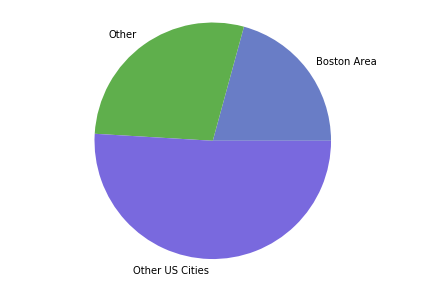

In [81]:
# Create a list of colors (from iWantHue)
colors = ["#697dc6","#5faf4c","#7969de","#b5b246",
          "#cc54bc","#4bad89","#d84577","#4eacd7",
          "#cf4e33","#894ea8","#cf8c42","#d58cc9",
          "#737632","#9f4b75","#c36960"]

# Create a pie chart
plt.pie( df_count_tweets_trump2['Count'], labels=df_count_tweets_trump2.index.get_values(), shadow=False, colors=colors)

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

In [82]:
# Create a filter from df_tweets filtering only those that have values for lat and lon
df_tweets_with_location2 = df_tweets_trump[df_tweets_trump.lon.notnull() & df_tweets_trump.lat.notnull()]
df_tweets_with_location2
#results show no tweets with location 

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time


In [89]:
df_tweets_trump.to_csv('twitter_data_trump.csv', sep=',', encoding='utf-8')